In [3]:
%matplotlib inline


Define the neural net
------------------
We want to be able to modify the hyperparameters easily, so the NN has to be designed in a modular way.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class Net(nn.Module):

    def __init__(self, n_layers = 4, first_layer_nodes = 16, batch_norm = True, 
                  dropout = None, data_dim = None, output_nodes = None):
        super(Net, self).__init__()
        
        ## initialize layers as a ModuleList(), a reguar list doesn't work, idk why
        self.layers = nn.ModuleList()

        ## the number of nodes in each layer is dependent on the nodes before it
        prev_nodes = data_dim

        for layer in range(n_layers):

          ## NN expands then contracts, symetrically
          if layer == 0:
            n_nodes = first_layer_nodes
          elif layer < n_layers / 2: 
            n_nodes = int(prev_nodes * 2)
          else:
            n_nodes = int(prev_nodes / 2)
          
          ## add the linear layer to the module list
          self.layers.append(nn.Linear(prev_nodes, n_nodes))
          
          ## add a batch normalization step
          if batch_norm:
            self.layers.append(nn.BatchNorm1d(1))

          if dropout != None:
            self.layers.append(nn.Dropout(dropout))
          
          ## update the number of nodes
          prev_nodes = n_nodes

        ## add the last layer to get the data into the final prediction size
        self.layers.append(nn.Linear(prev_nodes, output_nodes))

    def forward(self, x):
      ## Here we're just iterating through the NN layers, adding a ReLU if 
      ## it's a linear layer, or just running the layer if it's a batchNorm
        for layer in self.layers[0:-1]:
          if isinstance(layer, nn.Linear):
            x = F.relu(layer(x))
          elif isinstance(layer, nn.BatchNorm1d) or isinstance(layer, nn.Dropout):
            x = layer(x)
        
        x = self.layers[-1](x) ## last layer doesn't get relu
        return x

    def num_flat_features(self, x):
      ## this was a holdover function from the PyTorch tutorial, idk what it's for
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




# Define the optimization procedure



In [5]:
def train_net(X, y, model, optimizer, criterion, maxiter, epsilon, batch_size):
  
  prev_loss = 9999
  n_batches = int(X.shape[0] / batch_size)

  for iter in range(maxiter):
    for batch in range(n_batches):
      X_local = X[batch * batch_size : (batch + 1) * batch_size,:,:]
      y_local = y[batch * batch_size : (batch + 1) * batch_size, :,:]

      #print("X_local.shape ", X_local.shape)

      optimizer.zero_grad()   # zero the gradient buffers
      output = model(X_local)
      loss = criterion(output, y_local)
      loss.backward()
      optimizer.step()

    #  print("y_local: ", y_local[0:5,:, :])
    #  print("output: ", output[0:5, :, :])
      assert not math.isnan(loss)

    output = model(X)
    full_loss = criterion(output, y)   
   
    if iter % 10 == 0:
      print(full_loss)
      if (prev_loss - full_loss) <= epsilon:
        break
      prev_loss = full_loss
    
    

  return model, loss

# Load data

In [6]:
import torch.optim as optim
import pandas as pd
import numpy as np
from scipy.io import mmread
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

torch.cuda.set_device("cuda:0")


RNA = "drive/MyDrive/CIS_519_data/matrix.mtx"
ADT = "drive/MyDrive/CIS_519_data/raw_adt_counts.csv"

precipitates = pd.read_csv("drive/MyDrive/CIS_519_data/PAUMXB_precipitated_cells.csv")

## It's very slow to read the matrix, and takes a lot of memory, so once we've
## made the variance filtered one, we just use that directly 

'''   
X = pd.DataFrame(mmread(RNA).todense().T)
var_filtered = X.loc[:,np.var(X, axis = 0) >= 0.6]
var_filtered.to_csv("drive/MyDrive/CIS_519_data/RNA_expression_variance_filtered.csv")

del X
'''

## var_filtered is the X data, filtered to only genes with >= 0.6 var(counts)
var_filtered = pd.read_csv("drive/MyDrive/CIS_519_data/RNA_expression_variance_filtered.csv")

## read Y data. To make the problem more tractable with our limited compute power
## we're only going to try to impute 2 proteins for now. We're also going to 
## log transform our counts, as is typical in CITE-seq experiments
y = pd.read_csv(ADT)
y = y[["CD22.1", "CD2.1"]]
y = np.log(y + 1)

## split training and test. The most important part of ML is picking a lucky random state
X_train, X_test, y_train, y_test = train_test_split(var_filtered,y, test_size=0.25, random_state=19002)
precip_train = precipitates.iloc[X_train.index, :]
precip_test = precipitates.iloc[X_test.index, :]


Mounted at /content/drive


## Filter training data to just non-precipitated cells
We don't want to train on any of the garbage cells, or we'll be learning to recapitulate the junk instead of imputing what the junk should be.

       Unnamed: 0  26  78  154  190  ...  33555  33556  33557  33558  33559
2905         2905   0   0    9    0  ...      3      3      4     12      2
2997         2997   0   0    5    0  ...      2      2     81     41      1
21900       21900   0   0    8    0  ...      1      3      2     15      0
13262       13262   0   0    0    0  ...      5      2      3     12      2
21361       21361   0   0    8    0  ...      3     47      7     21      3

[5 rows x 1447 columns]


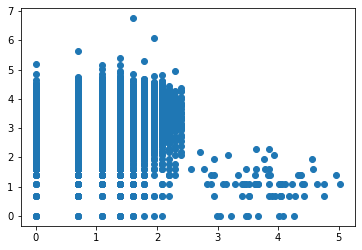

In [7]:
import matplotlib.pyplot as plt
print(X_train.head())
X_train = X_train.loc[precip_train["precip"] == 0, :]
y_train = y_train.loc[precip_train["precip"] == 0, :]

plt.scatter(y_train["CD22.1"], y_train["CD2.1"])
plt.show()


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_std = scaler.transform(X_train)

scaler_y = StandardScaler()
scaler_y.fit(y_train)
y_std = scaler_y.transform(y_train)

X_shape = X_std.shape
y_shape = y_std.shape

input = torch.from_numpy(X_std.T).reshape([X_shape[1], 1, X_shape[0]]).permute(2, 1, 0)
target = torch.from_numpy(y_std).reshape([y_shape[0], 1, y_shape[1]])
target.shape

del X_std
del y_std
#del y


# Train model, get loss

In [9]:
net = Net(n_layers = 4, first_layer_nodes = 64, data_dim = X_shape[1], 
            output_nodes = 2, batch_norm = True, dropout = 0.25).to("cuda:0")
print(net)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0005)
criterion = nn.MSELoss()

input = input.float().to("cuda:0")
target = target.float().to("cuda:0")

print(input.shape)
print(target.shape)
print(target.is_cuda)

trained, loss = train_net(input, target, net, optimizer, criterion, maxiter = 1000, 
                          epsilon = 0.00001, batch_size = 128)




Net(
  (layers): ModuleList(
    (0): Linear(in_features=1447, out_features=64, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)
torch.Size([15648, 1, 1447])
torch.Size([15648, 1, 2])
True
tensor(0.9372, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1913, device='cuda:

In [10]:
## save imputed and train Y
imputed = trained(input.float()).detach().cpu().numpy()
imp_train_df = pd.DataFrame(imputed.squeeze())
train_y_df = pd.DataFrame(target.cpu().numpy().squeeze())
imputation_df = pd.concat([imp_train_df, train_y_df], axis = 1)
imputation_df.columns = ["CD22_imp", "CD2_imp", "CD22_true", "CD2_true"]
imputation_df["set"] = "training"
imputation_df["precip"] = 0
imputation_df.head()

,CD22_imp,CD2_imp,CD22_true,CD2_true,set,precip
0,0.580134,0.668246,0.239791,0.488008,training,0
1,-0.493817,0.932818,-0.290484,0.867440,training,0
2,-0.203471,-1.407179,0.239791,-1.489812,training,0
3,-0.047381,-1.166788,-0.290484,-1.043688,training,0
4,-0.341116,0.992767,-0.290484,1.280545,training,0


## Test performance on validation set

Here we run the model on the validation set to test our imputation.

In [11]:
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(X_test)
X_test_std = scaler.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_test)
y_test_std = scaler_y.transform(y_test)

# ## Scale with the same transform as the training data
# X_test_std = scaler.transform(X_test)
# y_test_std = scaler_y.transform(y_test)

## get shape to make tensor
X_test_shape = X_test_std.shape
y_test_shape = y_test_std.shape
print(X_test_shape)

test_input = torch.from_numpy(X_test_std.T).reshape([X_test_shape[1], 1, X_test_shape[0]]).permute(2, 1, 0).to("cuda:0")
test_target = torch.from_numpy(y_test_std).reshape([y_test_shape[0], 1, y_test_shape[1]]).to("cuda:0")

imputed = trained(test_input.float()).detach().cpu().numpy()
imp_df = pd.DataFrame(imputed.squeeze())

y_df = pd.DataFrame(test_target.cpu().numpy().squeeze())

test_imputation_df = pd.concat([imp_df, y_df], axis = 1)
test_imputation_df.columns = ["CD22_imp", "CD2_imp", "CD22_true", "CD2_true"]
print(test_imputation_df.head())
test_imputation_df["set"] = "test"
test_imputation_df["precip"] = [i for i in precip_test["precip"]]

test_imputation_df.head()


(5496, 1447)
   CD22_imp   CD2_imp  CD22_true  CD2_true
0 -0.294413 -0.877221  -0.960699 -0.280694
1  0.038235 -1.065728  -0.960699 -0.649554
2  0.161414 -0.900344   0.530595 -0.870283
3  0.346643 -0.211391  -0.300791 -0.200043
4 -0.571628  1.135847   0.167421  0.945739


,CD22_imp,CD2_imp,CD22_true,CD2_true,set,precip
0,-0.294413,-0.877221,-0.960699,-0.280694,test,0
1,0.038235,-1.065728,-0.960699,-0.649554,test,0
2,0.161414,-0.900344,0.530595,-0.870283,test,0
3,0.346643,-0.211391,-0.300791,-0.200043,test,0
4,-0.571628,1.135847,0.167421,0.945739,test,0


In [12]:
all_imputation = pd.concat([test_imputation_df, imputation_df], axis = 0)
all_imputation.to_csv("drive/MyDrive/CIS_519_data/imputation_results.csv")
all_imputation

,CD22_imp,CD2_imp,CD22_true,CD2_true,set,precip
0,-0.294413,-0.877221,-0.960699,-0.280694,test,0
1,0.038235,-1.065728,-0.960699,-0.649554,test,0
2,0.161414,-0.900344,0.530595,-0.870283,test,0
3,0.346643,-0.211391,-0.300791,-0.200043,test,0
4,-0.571628,1.135847,0.167421,0.945739,test,0
...,...,...,...,...,...,...
15643,-0.802226,-2.494401,-1.037864,-3.047870,training,0
15644,-0.923832,1.336753,0.239791,1.528314,training,0
15645,-0.816948,-0.117398,-0.290484,-0.073535,training,0
15646,-0.256517,0.704664,-0.290484,1.212521,training,0


## Plot imputed results

Here we want to see the true vs imputed values for both CD2 and CD22, then we want to replicate the CD2 vs CD22 plot with imputed values, to see if we've removed the biologically implausable values.

0.5382988567009991
0.6733599934419234


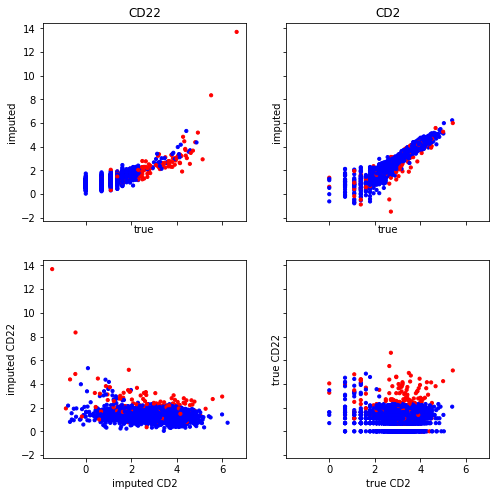

In [13]:
from sklearn.metrics import r2_score
f, axis = plt.subplots( 2, 2, sharey=True, sharex = True)
f.patch.set_facecolor('white')
  
f.set_figwidth(8)
f.set_figheight(8)

unscaled_imp = scaler_y.inverse_transform(imp_df)
unscaled_y = scaler_y.inverse_transform(y_df)

print(r2_score(unscaled_y[:,0], unscaled_imp[:,0]))
print(r2_score(unscaled_y[:,1], unscaled_imp[:,1]))

for i in range(2):
  axis[0,i].scatter(unscaled_y[:,i], unscaled_imp[:,i], s = 10,
                    c = ["blue" if i == 0 else "red" for i in precip_test["precip"]])
  axis[0,i].set_ylabel('imputed')
  axis[0,i].set_xlabel('true')
  axis[0,i].set_title(["CD22", "CD2"][i])


axis[1,0].scatter(unscaled_imp[:,1],unscaled_imp[:,0], s = 10,
                  c = ["blue" if i == 0 else "red" for i in precip_test["precip"]])
axis[1,0].set_ylabel('imputed CD22')
axis[1,0].set_xlabel('imputed CD2')


axis[1,1].scatter(unscaled_y[:,1],unscaled_y[:,0], s = 10,
                  c = ["blue" if i == 0 else "red" for i in precip_test["precip"]])
axis[1,1].set_ylabel('true CD22')
axis[1,1].set_xlabel('true CD2')

  
# Combine all the operations and display
plt.show()


## Plot imputation error
The error should be greater for precipitates than non-precipitates, and should be negatively skewed, because precipitates always cause an over-abundance of protein counts.

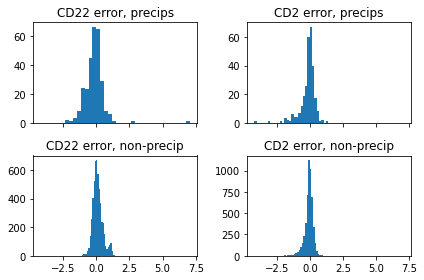

In [14]:
from matplotlib import colors

unscaled_imp = scaler_y.inverse_transform(imp_df)
unscaled_y = scaler_y.inverse_transform(y_df)

impute_error = unscaled_imp - unscaled_y
error_precips = impute_error[precip_test["precip"] == 1, :]
error_qual = impute_error[precip_test["precip"] == 0, :]

fig, axs = plt.subplots(2, 2, sharex=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0, 0].hist(error_precips[:,0], bins=32)
axs[0,0].set_title("CD22 error, precips")
axs[1, 0].hist(error_qual[:,0], bins=32)
axs[1, 0].set_title("CD22 error, non-precip")

axs[0, 1].hist(error_precips[:,1], bins=32)
axs[0,1].set_title("CD2 error, precips")
axs[1, 1].hist(error_qual[:,1], bins=32)
axs[1,1].set_title("CD2 error, non-precip")


plt.show()

## Hyperparameter sweep

Our ability to run many fold cross validation across all hyperparameters is limited by our GPU acces via colab (which times out after a certain amount of inactivity). Therefore, we conducted only a minimal hyperparameter sweep on 2 parameters, the learning rate and the dropout rate.

In [ ]:
learning_rates = [1e-4, 1e-5, 1e-6]
dropouts = [0, 0.3, 0.6]

lr = []
d = []
r2_cd22 = []
r2_cd2 = []

y_df = pd.DataFrame(test_target.cpu().numpy().squeeze())

for learning_rate in learning_rates:  
  for dropout in dropouts:
    net = Net(n_layers = 4, first_layer_nodes = 64, data_dim = X_shape[1], 
                output_nodes = 2, batch_norm = True, dropout = dropout).to("cuda:0")

    # create your optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    input = input.float().to("cuda:0")
    target = target.float().to("cuda:0")

    trained, loss = train_net(input, target, net, optimizer, criterion, maxiter = 1000, 
                              epsilon = 0.0001, batch_size = 128)

    imputed = trained(test_input.float()).detach().cpu().numpy()
    imp_df = pd.DataFrame(imputed.squeeze())

    lr.append(learning_rate)
    d.append(dropout)
    r2_cd22.append(r2_score(y_df.iloc[:,0], imp_df.iloc[:,0]))
    r2_cd2.append(r2_score(y_df.iloc[:,1], imp_df.iloc[:,1]))



tensor(0.7759, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1707, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0700, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0724, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1505, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6895, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4683, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2916, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2182, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1821, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1600, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1497, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1362, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1263, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1260, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1234, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1146, device='cuda:0', grad_fn=<MseLossBackward

In [ ]:
tuning = pd.DataFrame(np.asarray([lr, d, r2_cd22, r2_cd2]).T)
tuning.to_csv("drive/MyDrive/CIS_519_data/LR_dropout_tuning.csv")
tuning

,0,1,2,3
0,0.000100,0.0,0.051906,0.708569
1,0.000100,0.3,0.494343,0.756087
2,0.000100,0.6,0.367258,0.713658
3,0.000010,0.0,-0.141552,0.472041
4,0.000010,0.3,0.300619,0.722093
5,0.000010,0.6,0.014981,0.537127
6,0.000001,0.0,-0.109301,0.467586
7,0.000001,0.3,-0.236413,-0.002362
8,0.000001,0.6,-0.697690,-0.570446
